# Processamento de Imagem e Visão
## Trabalho Prático 1
### Alunos: Belarmino Sacate (52057) e Miguel Ferreira (51878)

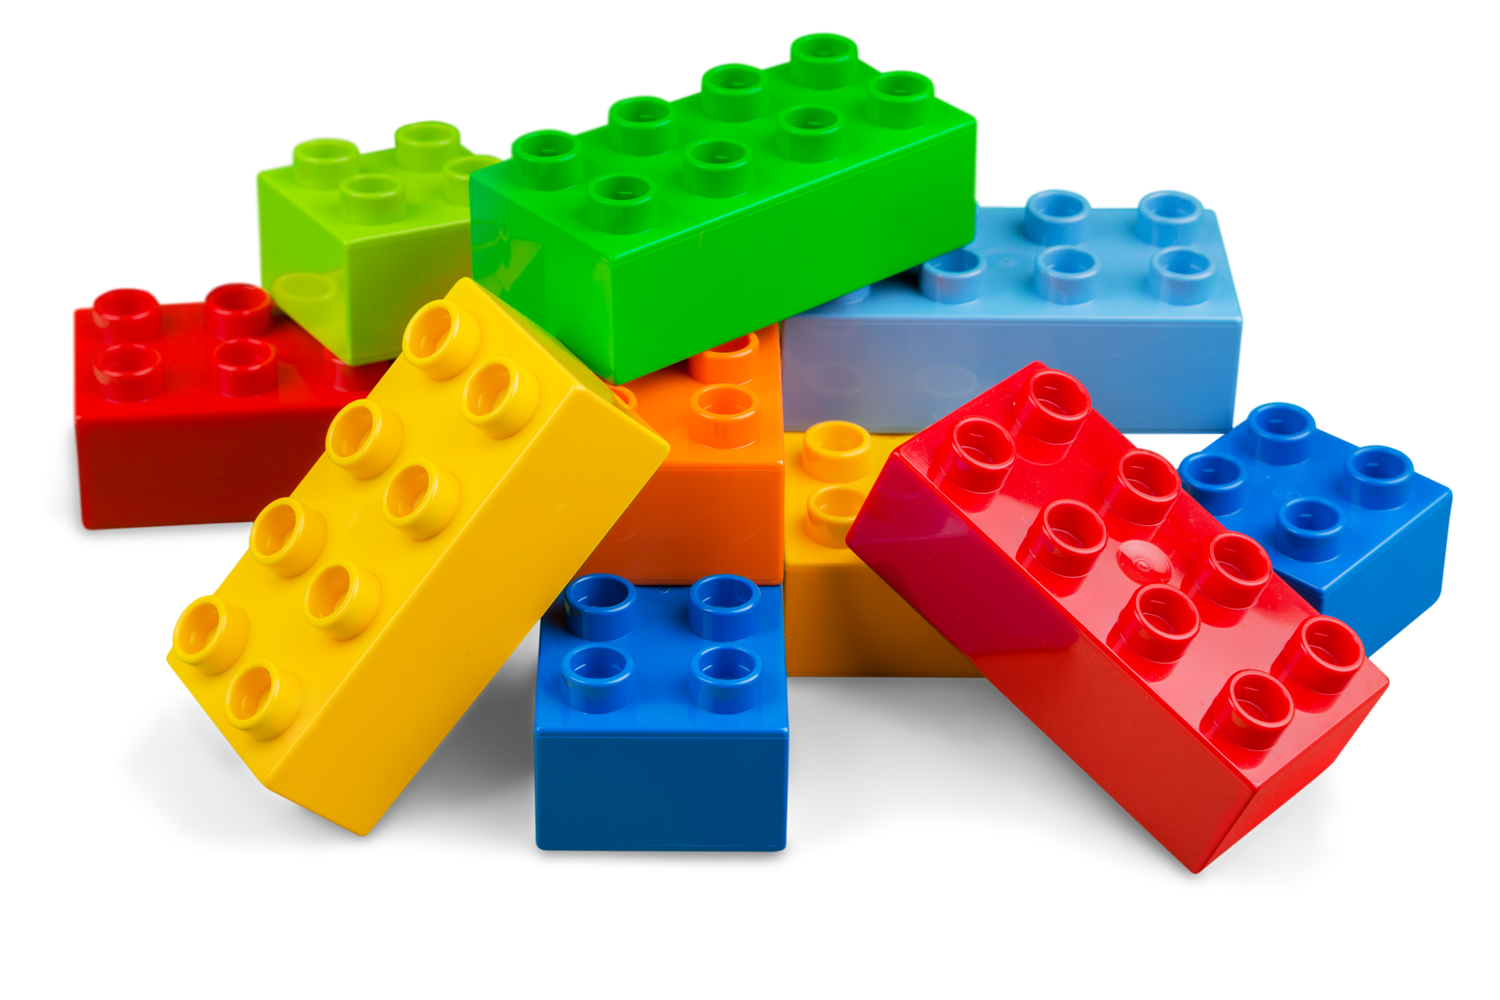

------
# 1. INTRODUÇÃO

Este trabalho foi desenvolvido para aprofundar conhecimento em Processamento de Imagem e Visão com o objetivo de criar um algoritmo que seja capaz de identificar peças de lego de outros objetos numa imagem, bem como, classificá-las de acordo com a sua proporção (2x2, 2x4, 2x6 e 2x8).
Desta forma, foi permitido o uso da biblioteca OpenCV, que é uma das ferramentas mais utilizadas para o desenvolvimento de projetos nesta área.
O programa desenvolvido inclui várias secções que transformam a imagem progressivamente até obter os resultados finais.

------

# 2. ESTRUTURA

- #### Pré-processamento:

    Leitura e armazenamento das imagens em um dicionario.

- #### Máscaras:

  
    Criação de máscaras binárias através de um intervalo de cor que remove o fundo.

- #### Operadores Morfológicos:

    Aplicação dos operadores CLOSE e OPEN para eliminar buracos dentro das peças.

  
    Utilização de Erosão e Dilatação para o ajuste do escalamento das pecas.

- #### Características:

  
    Deteção da área do objeto.

    Cálculo do retângulo mínimo para cada contorno.

    Extração das características (Área, área do retângulo mínimo, diferênça entre as áreas e as proporções das peças).

- #### Classificação:


  Definição de valores experimentais com base nos resultados obtidos.


  Restrição da classificação a objetos grandes o suficiente para serem peças de lego.


  Comparação do rácio entre a área do contorno e retângulo mínimo para verificar a forma retângular das peças.


  Classificação final, baseada principalmente nas suas proporções.

-------------
## BIBLIOTECAS

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

------------
## 3. MÉTODOS

Esta função carrega todas as imagens presentes numa pasta expecífica. Ela percorre os ficheiros presentes e seleciona apenas as imagens, através das extenções jpg, png e jpeg.

Cada imagem é guardada num dicionário onde a chave é o nome do ficheiro e o valor é a imagem em si. Logo, consegui-mos aceder todas as imagens facilmente, evitando assim necessidade de ter que se carrregar as imagens sempre que houver necessidade de se testar o classificador.

In [4]:
def carregar_imagens(pasta):
    imagens = {}
    
    for nome_ficheiro in os.listdir(pasta):
        if nome_ficheiro.lower().endswith(('.jpg', '.png', '.jpeg')):
            caminho = os.path.join(pasta, nome_ficheiro)
            imagem = cv2.imread(caminho)
            imagens[nome_ficheiro] = imagem
    return imagens

Este metodo foi utilizado para a conversao da imagem de BGR para RGB

In [5]:
def converter_para_rgb(imagem):
    return cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

A função refinar_mascara() usa vários operadores morfológicos para melhorar a qualidade da máscara binária gerada.

É usado um elemento estruturante, ou seja, uma matriz pequena, com e tamanho e forma diferente. O elemento estruturante determina o tamanho e figura geometrica a ser utilizada no operador morfologico.


Foi escolhido o elemento estruturante eliptico pois notou-se que com o uso do elemento estruturante rectangular os cantos dos contornos ficavam cortados perdendo-se um pouco da informacao do componente conexo que poderia influenciar mais para frente na classificao dos diversos objectos, para evitar com que isso acontecesse optamos pelo uso do elemento estrurante eliptico que preserva melhor os cantos dos objetos, mantendo o formato dos objetos mais proximo dos orignais.


Em primeiro lugar, foi utilizado o MORPH_CLOSE, que é uma dilatação sucedida de uma erosão, com o objetivo de fechar pequenos buracos nas peças de lego. Estes buracos surgiram principalmente nas peças com a cor mais próxima do fundo azul (Peca verde 2x6 Lego21 e Lego30). 

De seguida usou-se o MORPH_OPEN, ou seja, uma erosão seguida de uma dilatação, para remover pequenos defeitos nos contornos dos objetos ou falsos positivos detetados na imagem.

Finalmente, foi feita uma erosão e dilatação com matrizes maiores com o objetivo de alimar todas as peças detetadas, suavizando os contornos, tornando-as mais fáceis de classificar.

In [6]:
def refinar_mascara(mascara):
    kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    kernel2= cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    kernel3= cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (30, 30))
    kernel4= cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))

    mascara_close = cv2.morphologyEx(mascara, cv2.MORPH_CLOSE, kernel1)
    mascara_open = cv2.morphologyEx(mascara_close, cv2.MORPH_OPEN, kernel2)
    mascara_erosao = cv2.erode(mascara_open, kernel3)
    mascara_final = cv2.dilate(mascara_erosao, kernel4)

    return mascara_final

A função seguinte aplica a máscara binária gerada na imagem original através da operação bitwise. Nesta operação, os pixeis com valor 0, correspondentes à área preta na imagem, tornam-se pretos na imagem resultante. Os pixeis branco mantêm as cores da imagem originais.

In [7]:
def aplicar_mascara(imagem, mascara):
    return cv2.bitwise_and(imagem, imagem, mask=mascara)

Este método é responsável por guardar as imagens no computador. Os resultados foram colocados na pasta do mesmo nome.

In [8]:
def gravar_imagem(imagem, nome_arquivo):
    cv2.imwrite(nome_arquivo, imagem)

Esta função cria uma máscara binária a partir dos limites de cores definidos. É utilizado o cv2.inRange(), que irá transformar as cores dentro do intervalo fornecido. Estas são transformadas em preto (0). As cores restantes que correspondem às peças ficam brancas (1).

In [9]:
def criar_mascara_por_cor(imagem_rgb, cor_inferior, cor_superior):
    mascara = cv2.inRange(imagem_rgb, cor_inferior, cor_superior)
    return mascara

Esta função permite ver a imagem numa janela à parte, esperando que uma tecla seja pressionada antes de fechar a própria janela.

In [10]:
def exibir_imagem_cv2(titulo, imagem):
    cv2.imshow(titulo, imagem)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Esta função calcula algumas propriedades para cada objeto identificado através do seu contorno. 

Primeiramente, obtemos a área de um objeto detetado na imagem, que pode ser uma peça de Lego ou não. De seguida, aplica-se o método minAreaRect() que gera o retângulo mínimo que consegue preencher o objeto todo. 

De seguida, é calculado o rácio entre a área real e o retângulo mínimo. Como o objetivo é identificar peças de Lego, as quais são retângulares, as duas áreas serão muito parecidas. Assim, conseguimos separar peças de Lego e outros objetos irregulares através da comparação destas duas áreas. 

Por fim, é calculada a razão entre a altura e largura da peça. Para garantir que as proporções possam ser comparadas corretamente, é usado um "if" que garante que o valor seja sempre maior ou igual a 1.

In [11]:
def extracao_propriedades(contorno):
    
    #area do contorno da peça
    area = cv2.contourArea(contorno)

    #retangulo minimo
    rect = cv2.minAreaRect(contorno)
    box = cv2.boxPoints(rect)
    box = np.int32(box)
    
    #racio de area
    area_rect = cv2.contourArea(box)
    if area_rect == 0:
        racio = 0
    else:
        racio = (area / area_rect) * 100
        
    (x, y), (w, h), a = rect
    
    if min(w, h) == 0:
        aspect_ratio = 0
    else:
        aspect_ratio = max(w, h) / min(w, h)

    return area, aspect_ratio, box, racio

A função classificacao_peca() usa as informações obtidas de cada contorno para identificar se o objeto é uma peça de Lego, pela sua forma retângular, bem como, classificá-las quanto à sua proporção. 

Para a classificação, foi usado um rácio, o qual foi definido como 89%, com o objetivo de detetar objetos que não fossem retângulares. Este valor parece baixo mas foi escolhido para acomodar uma imagem onde existem duas peças sobrepostas, as quais devem ser identificadas como uma só peça. 
Assim, para acomodar a existência deste tipo de peças foi escolhido este valor limite, que para além de identificá-las corretamente, conseguiu ser suficiente para definir as peças de lego deitadas ao comprido (1x2), as quais têm rácios à volta dos 87%, como indefinidas.

Para além disso, utilizaram-se proporções para identificar o tipo das peças na imagem. Esta proporção é calculada anteriormente, sendo que através dos resultados nas imagens de teste, foi possível identificar, com o olho humano, o tipo de cada peça e o intervalo que as engloba. Os valores resultantes acabaram por ser bastante largos pelo facto da remoção do fundo e aplicação de operadores morfológicos introduzirem erro nos contornos de cada peça. Assim, apesar de não serem teóricamente corretos, apresentam um intervalo grande o suficiente para dar alguma margem de erro ao método que calcula a área e posteriormente área retangular mínima da peça. 

###### Definicao dos intervalos:
- Os intervalos das pecas 2x2 foram obtidos pelas caracteristicas da peca 2x2 da imagem lego30 com 1.0052701794823504 de aspect_ratio e da peca 2x2 da imagem Lego02 com aspect ratio de 1.0575540322930164.

- Os intervalos das pecas 2x4 foram obtidos pelas caracteristicas da peca 2x4 da imagem lego09 com 2.0978173322114304 de aspect_ratio e da peca 2x4 da imagem Lego10 com aspect ratio de 2.4389900175658945.


- Os intervalos das pecas 2x6 foram obtidos pelas caracteristicas da peca 2x6 da imagem lego13 com 3.1593424258480223 de aspect_ratio e da peca 2x6 da imagem Lego21 com aspect ratio de 3.5647978047869007.


- Os intervalos das pecas 2x8 foram obtidos pelas caracteristicas da peca 2x8 da imagem lego11 com 4.24018011872401 de aspect_ratio e da peca 2x8 da imagem Lego02 com aspect ratio de 4.855026217104629.



In [12]:

def classificacao_peca(area, aspect_ratio, racio, min_area):
    
    if area > min_area:

        #area diferenca
        if racio < 89:
            return "indefinido"
    
        #aspect ratio
        if 1 < aspect_ratio < 1.07:
            return "2x2"
        elif 1.8 < aspect_ratio < 2.44:
            return"2x4"
        elif 3.15 < aspect_ratio < 3.57:
            return "2x6"
        elif 4.24 < aspect_ratio < 4.86:
            return "2x8"
        else:
            return "indefinido"

------------
# 4. EXECUÇÃO

Para facilitar a execução das funções, seguimos a dica dada pelo professor, que consistia em carregar todas as imagens de teste e armazená-las em um dicionário, evitando assim a necessidade de, sempre que quiséssemos testar o classificador em uma imagem, ter que carregá-las novamente.

Temos especificado o caminho até a pasta imagens (pasta_treino), que contém as imagens de treino fornecidas e que, por sua vez, são carregadas pela função carregar_imagens.

Para tornar a execução mais prática, fizemos um ciclo for para percorrer todas as imagens carregadas anteriormente. criamos uma tambem a variável "nome" para obter o nome da imagem correspondente à iteração em que o "for" estiver, permitindo assim acessar o conteúdo dessa imagem e armazená-lo na variável "img".


O proximo passo foi a criacao de intervalos inferiores e superiores referentes a cor azul(fundo_inferior e fundo_superior) para podermos posteriormente fazer a aplicao da mascara (aplicar_mascara), retirando assim o fundo azul.
O intervalo da cor de fundo foi escolhido com base na observação das imagens de treino. Para isso, identificaram-se os valores do intervalo que compõe os azuis recorrendo a uma aplicação externa (Paint). De seguida, realizaram-se testes consecutivos até garantir que a peça nas imagens que possui a cor mais perto do azul, fosse separada do fundo corretamente.

Para o conseguirmos dectetar os contornos dos objectos usamos a funcao findContours especificamos os seguintes parametros:
mascara_refinada - mascara melhorada atraves dos operadores morfogicos
cv2.RETR_EXTERNAL - refere a identificacao de contornos externos
cv2.CHAIN_APPROX_SIMPLE - armazena apenas os pontos essenciais

E para desenharmos os contornos usamos a funcao cv2.drawContours() espificiando os seguintes parametros:
imagem_com_contornos - copia da imagem orignal onde os contornos serao desenhados
contornos - É a lista de contornos retornada por cv2.findContours.
-1 - serve para indicar que quer desenhar todos os contornos do array contornos.
(0, 255, 0) - cor dos contornos que serao desenhados
2 - espessura da linha


Tendo completado este passo, avancamos finalmente para a extracao de caracteristicas e classificao.

Iniciamos um novo ciclo for para percorrer cada contorno encontrado na mascara.
Dentro deste ciclo, começamos por calcular um retângulo delimitador(bounding box) para cada objecto. (x, y, w, h = cv2.boundingRect(contorno))

Onde:
x e y - representam as coordenadas do canto superior esquerdo do objecto.
w e h - correspondem à largura e altura.

Criamos também uma variável "min_area", utilizada para evitar que pequenas imperfeições do fundo sejam classificadas como peças (escolheu-se o valor de 1200 por termos na imagem Lego10 um pedaco da personagem de lego com o valor de 1229.0), definimos tambem uma variável "margem", usada para evitar que peças encostadas aos contornos da imagem sejam consideradas. Essa foi a solução que encontramos para garantir que a peça de lego cinzenta presente na imagem “lego30” fosse ignorada.

A variável "margem" é usada em conjunto com as variáveis "image_h" e "image_w", que armazenam a altura e a largura da imagem. usamos essas variáveis ajudaram-nos a verificar se os lados dos contornos estavam muito próximos das bordas da imagem. Caso não estejam, o objeto segue para a extração das propriedades e  classificação, caso contrário, o objecto é ignorado.

Após a classificação, armazenamos os resultados (tipo, área e aspect_ratio) dentro do array pecas_classificadas, esse array armazena todas as informações das peças apos a classificao. Por fim, escrevemos na imagem os tipos de peças encontrados e gravamos as imagens resultantes na pasta resultados.

In [13]:
pasta_treino = "./imagens"
imagens = carregar_imagens(pasta_treino)
print(len(imagens), "imagens carregadas.")

14 imagens carregadas.


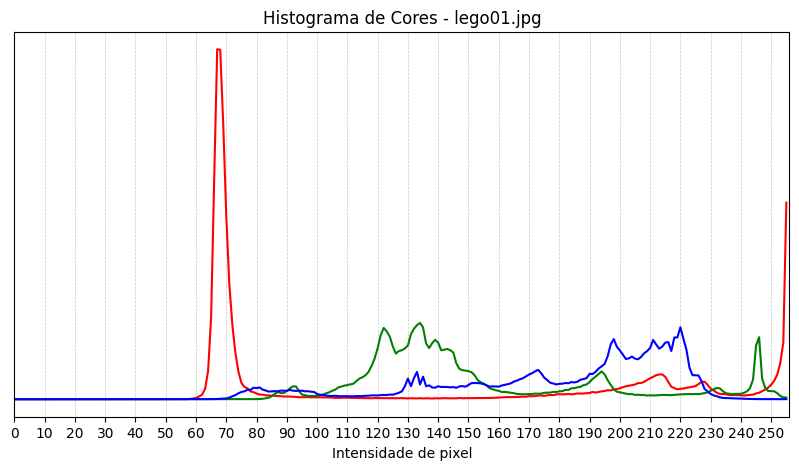

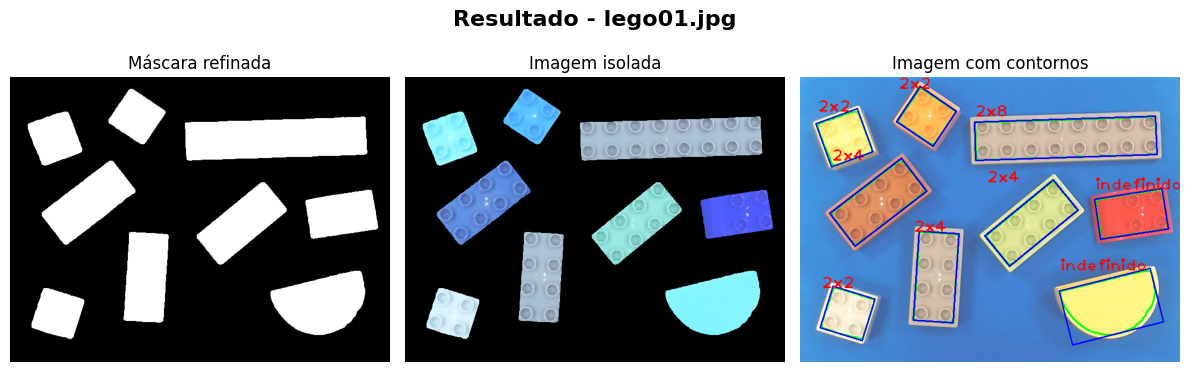

[('2x2', 6258.5, 1.0185459462757018, 95.0850805226375), ('indefinido', 14304.5, 1.6981133559283204, 80.01174628034455), ('2x4', 11897.0, 2.2287120806750362, 96.99959233591521), ('indefinido', 9194.5, 1.6901095462486133, 96.03613954459996), ('2x4', 11580.5, 2.262927433253323, 97.34784801613988), ('2x4', 12463.5, 2.1747574239140945, 96.56388006508097), ('2x8', 23246.0, 4.72916654163348, 97.18633722145574), ('2x2', 6614.0, 1.0341685015748046, 94.8651749856569), ('2x2', 6092.0, 1.0486331140075251, 95.35884792987399)]


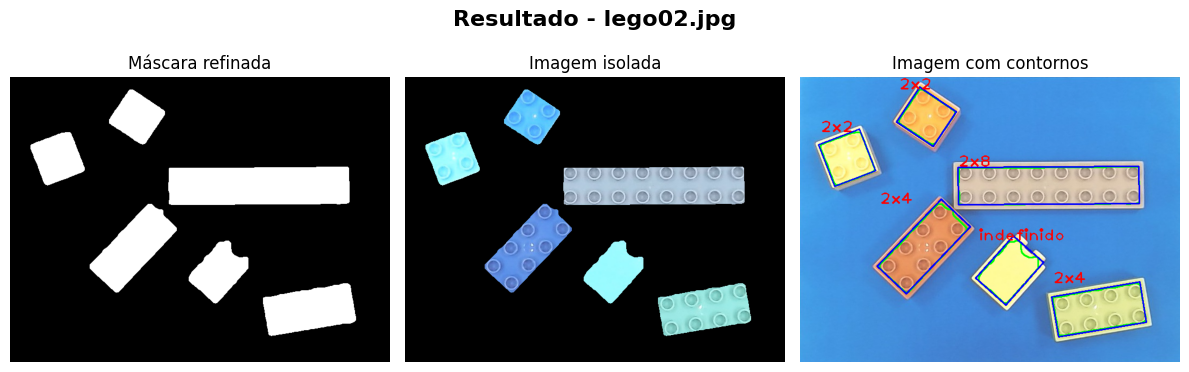

[('2x4', 11884.5, 2.2030567736474285, 94.89001556948381), ('indefinido', 7019.0, 1.4093438095871682, 89.28889454267906), ('2x4', 12058.5, 2.3090184987144515, 94.4653349001175), ('2x8', 22721.5, 4.855026217104629, 97.99663590097472), ('2x2', 6434.0, 1.0203001179796636, 95.71556084498661), ('2x2', 6033.5, 1.0575540322930164, 95.12810405991328)]


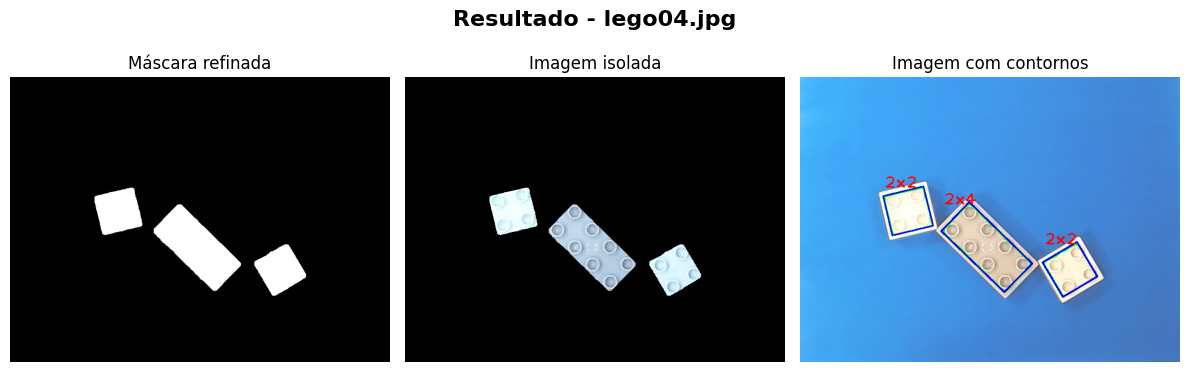

[('2x2', 5307.0, 1.0110100879359758, 95.7942238267148), ('2x4', 11765.5, 2.203319481563745, 96.74382271923693), ('2x2', 5572.5, 1.0285156086741853, 95.64060756886639)]


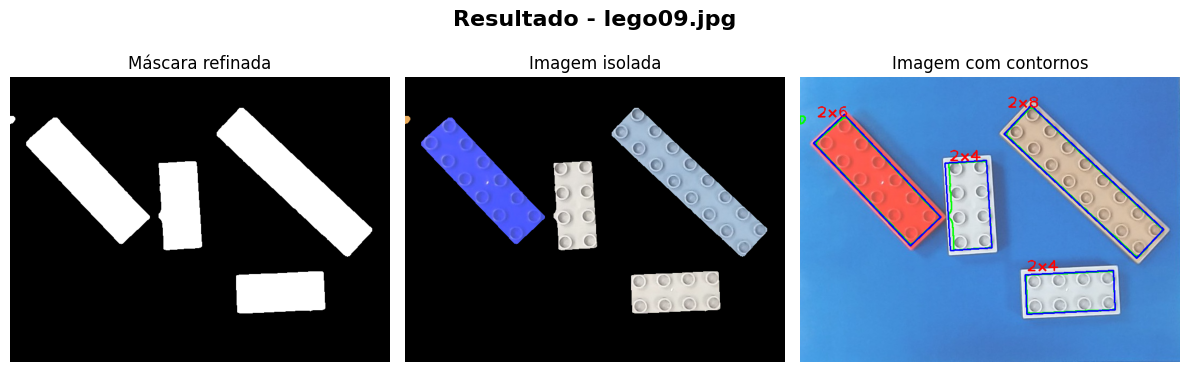

[('2x4', 11538.0, 2.2434780594089414, 96.18206068689562), ('2x4', 11369.0, 2.0978173322114304, 90.77770680293837), ('2x6', 19541.0, 3.3866671974050853, 96.50591401832234), ('2x8', 23734.5, 4.666221242589581, 96.72548699975549)]


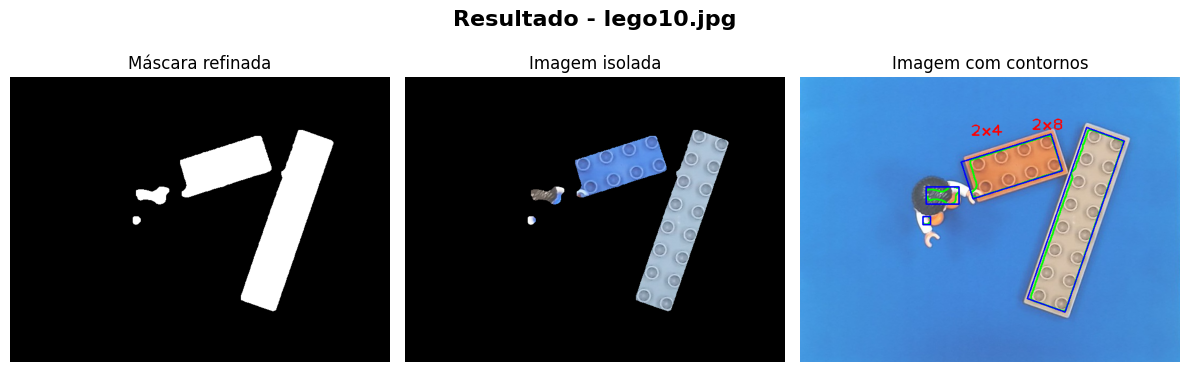

[(None, 172.5, 1.0714285714285714, 82.14285714285714), (None, 1229.0, 1.90625, 62.96106557377049), ('2x4', 11236.5, 2.4389900175658945, 90.32556270096464), ('2x8', 23116.0, 4.525254370481916, 92.68644747393745)]


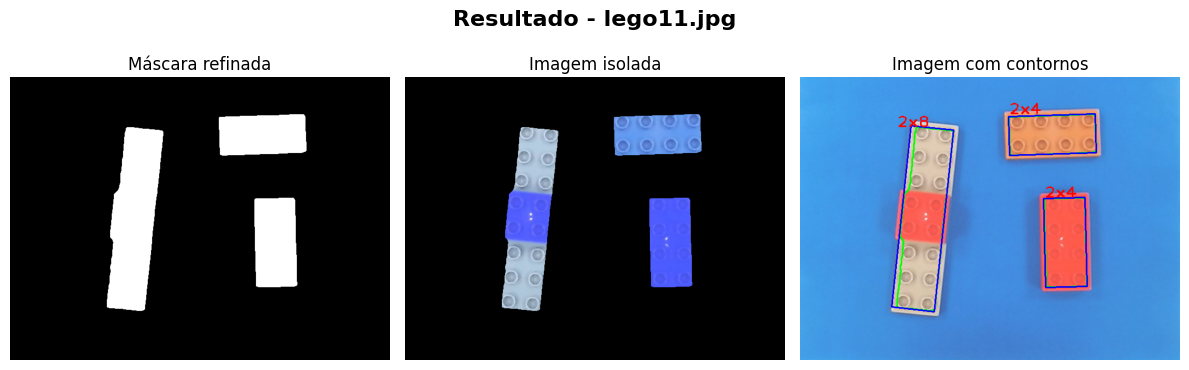

[('2x4', 12358.5, 2.148955480025358, 97.21151577125778), ('2x8', 24332.5, 4.24018011872401, 90.49071198795069), ('2x4', 11348.0, 2.230873262225251, 97.81072228926048)]


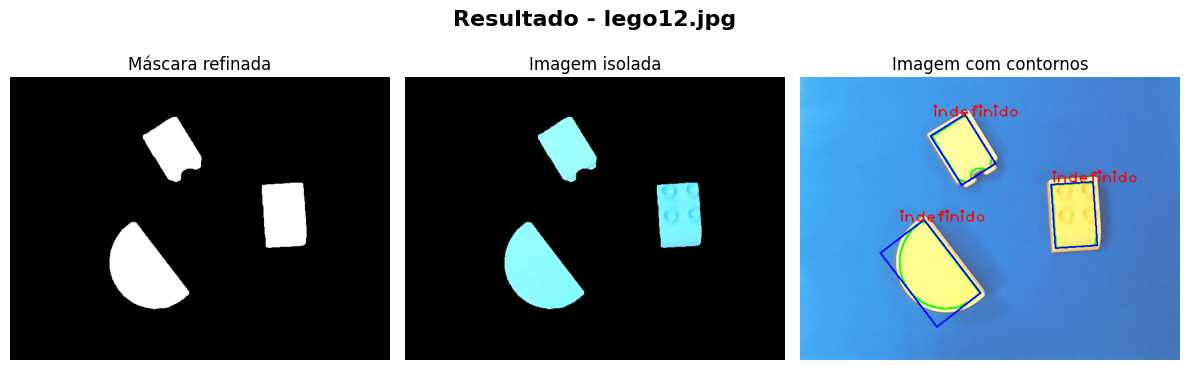

[('indefinido', 14191.0, 1.68383014868785, 80.54373119927351), ('indefinido', 8882.5, 1.5100146299713115, 96.0893552574643), ('indefinido', 7393.0, 1.4289730860019796, 91.51451383301355)]


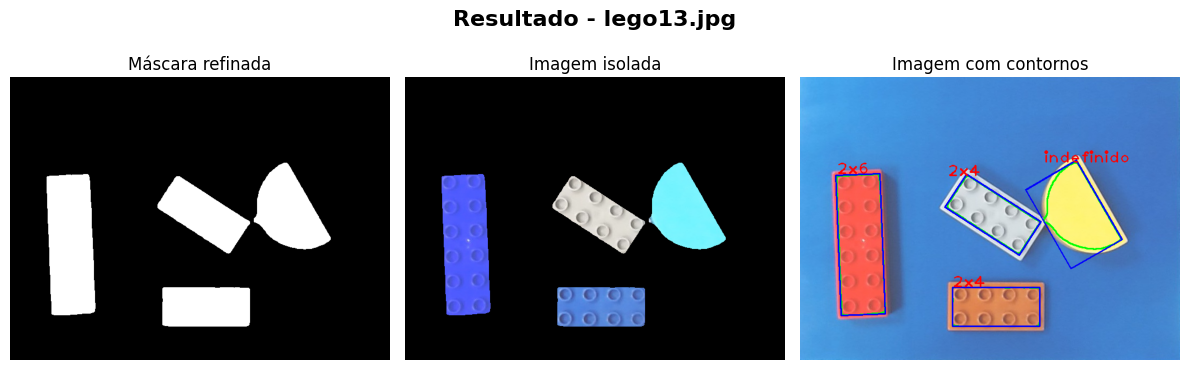

[('2x4', 11598.0, 2.25, 99.43415637860082), ('2x4', 11495.0, 2.248934105351571, 95.57661927330173), ('2x6', 20804.0, 3.1593424258480223, 97.44262295081967), ('indefinido', 13555.0, 1.5541284010455134, 73.47082576763599)]


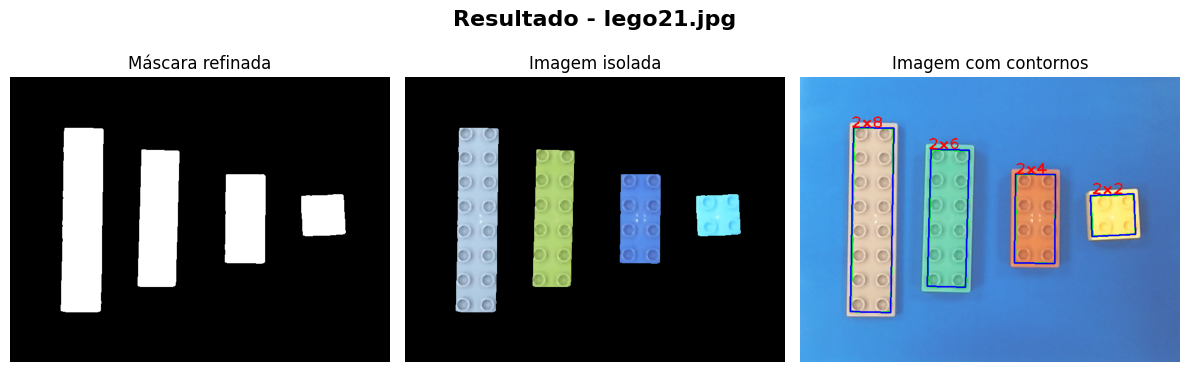

[('2x2', 5838.5, 1.0649418201685714, 95.30688867123735), ('2x4', 12034.5, 2.2186982378563367, 97.88921425085407), ('2x6', 17679.0, 3.5647978047869007, 97.95545212765957), ('2x8', 24887.0, 4.557894178928544, 97.13326698280741)]


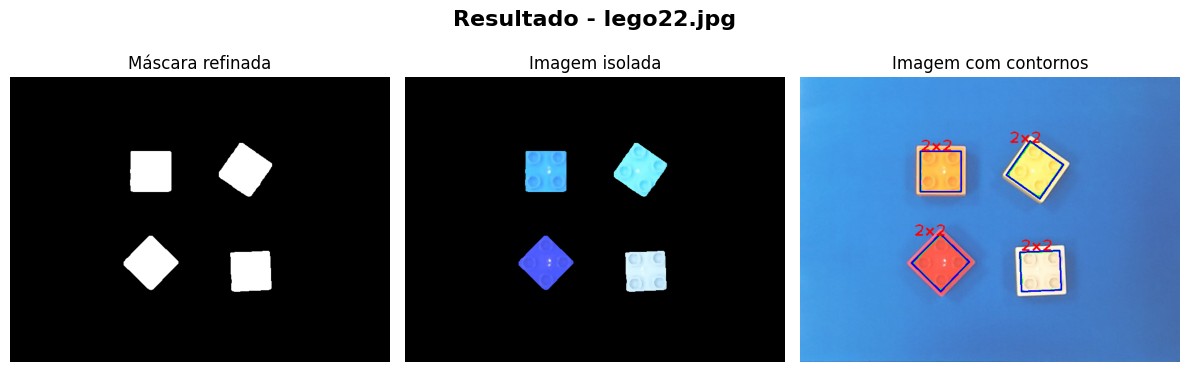

[('2x2', 5260.0, 1.0167714675304598, 97.20938828312697), ('2x2', 5571.5, 1.010322978111758, 97.31027857829011), ('2x2', 5630.0, 1.0133333333333334, 98.7719298245614), ('2x2', 5580.5, 1.0194385409337563, 95.52379322149949)]


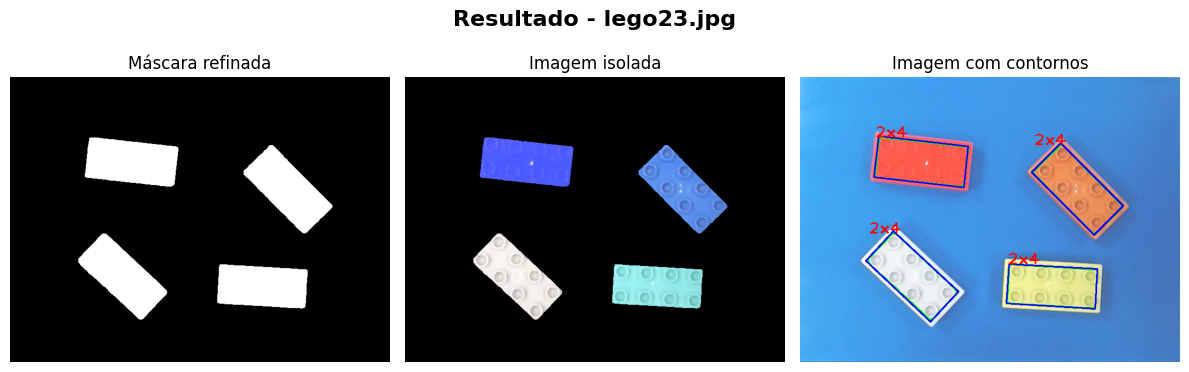

[('2x4', 11768.0, 2.250608475590586, 96.98767874067664), ('2x4', 12042.5, 2.168141671212489, 96.48279453591316), ('2x4', 12267.0, 2.1481483257546423, 97.91666666666666), ('2x4', 12429.5, 2.1950657110486973, 96.98802231672585)]


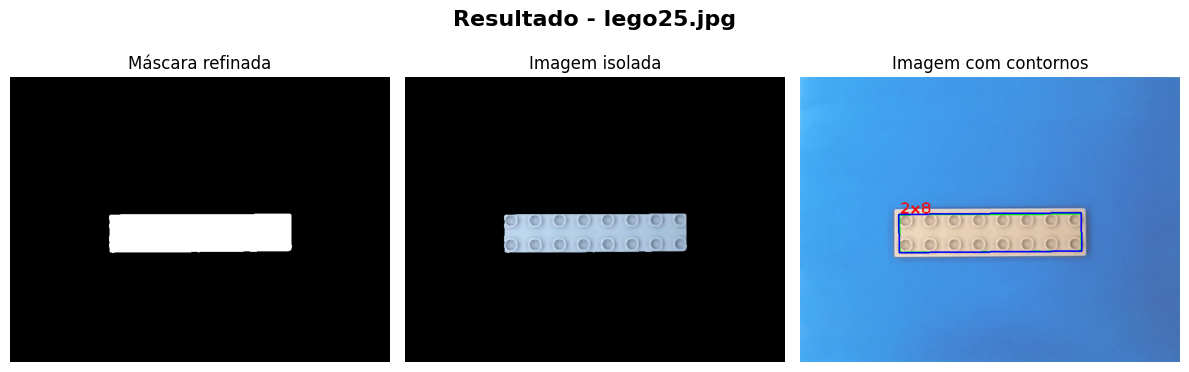

[('2x8', 23416.5, 4.780118350222553, 97.27691924227318)]


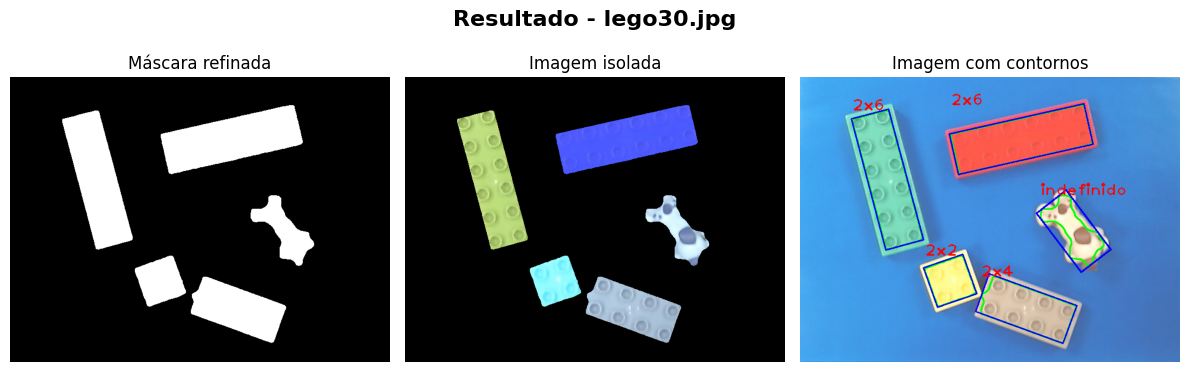

[('2x4', 12163.5, 2.3055873360071, 94.44077798051167), ('2x2', 5714.0, 1.0052701794823504, 95.56782070580364), ('indefinido', 5881.5, 1.971682173160881, 61.58638743455498), ('2x6', 17517.5, 3.497307030427186, 97.0659943480911), ('2x6', 19278.0, 3.304785594022033, 97.84793421987615)]


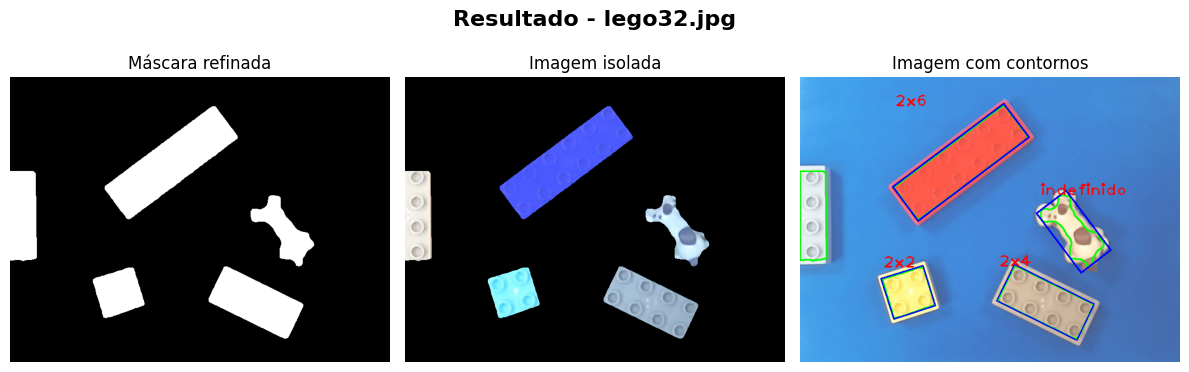

[('2x2', 5990.5, 1.0429118164910252, 94.34601149696826), ('2x4', 11979.0, 2.2223235862766613, 97.21636098036032), ('indefinido', 5836.0, 2.0001678358790653, 61.1996644295302), ('2x6', 19448.5, 3.3086393747685663, 96.58331884885656)]


In [39]:
nomes = list(imagens.keys())

for i in range(len(imagens)):
    #selecao da imagem
    nome = nomes[i]
    img = imagens[nome] 

    imgrgb = converter_para_rgb(img)


    #definicao dos intervalos de cor do fundo
    fundo_inferior = np.array([90, 0, 0])      
    fundo_superior = np.array([255, 255, 255])


    #criacao e aplocacao da mascara
    mascara_fundo = criar_mascara_por_cor(imgrgb, fundo_inferior, fundo_superior)
    mascara_refinada = refinar_mascara(mascara_fundo)
    imagem_isolada = aplicar_mascara(img, mascara_refinada)


    #desenho dos contornos dos objectos
    contornos, _ = cv2.findContours(mascara_refinada,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

    #desenho dos contornos na imagem original
    imagem_com_contornos = img.copy()
    cv2.drawContours(imagem_com_contornos, contornos, -1, (0, 255, 0), 2)
    

    pecas_classificadas = []

    image_h = img.shape[0]
    image_w = img.shape[1]

    min_area = 1250

    for contorno in contornos:
        
        x, y, w, h = cv2.boundingRect(contorno)
        margem = 10
        if x <= margem or y <= margem or x + w >= image_w - margem or y + h >= image_h - margem:
            continue
        else:
            area, aspect_ratio, box, racio = extracao_propriedades(contorno)
            cv2.drawContours(imagem_com_contornos, [box], 0, (255, 0, 0), 2)

            tipo = classificacao_peca(area, aspect_ratio, racio, min_area)

            pecas_classificadas.append((tipo, area, aspect_ratio, racio))

            x, y, w, h = cv2.boundingRect(contorno)
            posicao_texto = (x, y)
            posicao_texto_2 = (x, y - 50)  

            cv2.putText(imagem_com_contornos, tipo, posicao_texto, cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)
            #if area > min_area:
                #cv2.putText(imagem_com_contornos, str(aspect_ratio), posicao_texto_2, cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 2)



    if i == 0:
        plt.figure(figsize=(10, 5))
        cores = ('r', 'g', 'b')
        for j, cor in enumerate(cores):
            hist = cv2.calcHist([imgrgb], [j], None, [256], [0, 256])
            plt.plot(hist, color=cor)
            plt.xlim([0, 256])

        plt.title(f"Histograma de Cores - {nome}")
        plt.xlabel("Intensidade de pixel")
        plt.grid(True, linewidth=0.5, linestyle='--', alpha=0.7)
        plt.xticks(np.arange(0, 257, 10))
        plt.yticks([])
        plt.show()


    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(mascara_refinada, cv2.COLOR_GRAY2RGB))
    plt.title('Máscara refinada')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(imagem_isolada)
    plt.title('Imagem isolada')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(imagem_com_contornos, cv2.COLOR_BGR2RGB))
    plt.title('Imagem com contornos')
    plt.axis('off')

    plt.suptitle(f"Resultado - {nome}", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


    gravar_imagem(cv2.cvtColor(mascara_refinada, cv2.COLOR_GRAY2BGR), f"resultados/mascara_refinada_{i}.jpg")
    gravar_imagem(cv2.cvtColor(imagem_isolada, cv2.COLOR_RGB2BGR), f"resultados/imagem_isolada_{i}.jpg")
    gravar_imagem(imagem_com_contornos, f"resultados/imagem_com_contornos_{i}.jpg")

    print(pecas_classificadas)

------------
# 5. CONCLUSÃO

Concluindo, este trabalho permitiu desenvolver um algoritmo de identificação e classificação de peças de LEGO retângulares das proporções (2x2, 2x4, 2x6 e 2x8) sobre um fundo azul. Para isso, foram aplicadas técnicas de processamento de imagem e visão que conseguem retirar as características dos objetos detetados na imagem. Assim, consegui-mos aprofundar os nossos conhecimentos em OpenGL, tornando-se numa base para os trabalhos seguintes.